In [29]:
from ipynb.fs.full.regression import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_regression, f_classif
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split

In [30]:
data.head(3)

,rating,nb_reviews,Price/hour in USD,nb_projects,nb_buyers,last_active,score,lang_english,lang_french,lang_spanish,...,skill_blog_writing,skill_content_writing,skill_web_writing,skill_social_media_marketing,skill_article,skill_search_engine_optimization,skill_editing,gender_male,gender_female,gender_undefined
0,4.9,4694,34.74,7672,4168,1,10.043,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1,5.0,1190,138.95,1085,533,1,8.691,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1
3,4.9,598,20.00,721,376,1,7.983,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1


### ANOVA F-value For Feature Selection

https://www.kaggle.com/prashant111/comprehensive-guide-on-feature-selection/notebook

In [31]:
X = data.drop(['Price/hour in USD'], axis=1)
y = data['Price/hour in USD']

X.shape

(7073, 54)

Compute the ANOVA F-value for the provided sample.

The F-value scores examine if, when we group the numerical feature by the target vector, the means for each group are significantly different.

Compare Chi-Squared Statistics

In [32]:
# Select Features With Best ANOVA F-Values

# Create an SelectKBest object to select features with k best ANOVA F-Values
selector = SelectKBest(f_classif, k=20)
# Apply the SelectKBest object to the features and target
X_new = selector.fit_transform(X, y)
X_new.shape

C:\Users\remij\Miniconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [46] are constant.
  UserWarning)
C:\Users\remij\Miniconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


(7073, 20)

In [33]:
# Select select features based on top percentiles

selector = SelectPercentile(f_classif, percentile=40)
X_new = selector.fit_transform(X, y)
X_new.shape

C:\Users\remij\Miniconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: UserWarning: Features [46] are constant.
  UserWarning)
C:\Users\remij\Miniconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


(7073, 22)

In [34]:
cols = selector.get_support(indices=True)
X = X.iloc[:,cols]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

model = sm.OLS(y_train.astype(float), X_train.astype(float))
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:      Price/hour in USD   R-squared (uncentered):                   0.447
Model:                            OLS   Adj. R-squared (uncentered):              0.444
Method:                 Least Squares   F-statistic:                              193.8
Date:                Mon, 24 May 2021   Prob (F-statistic):                        0.00
Time:                        10:38:19   Log-Likelihood:                         -26442.
No. Observations:                5304   AIC:                                  5.293e+04
Df Residuals:                    5282   BIC:                                  5.307e+04
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

### Optimization of Coefficient of determination

In [49]:
X = data.drop(['Price/hour in USD'], axis=1)
y = data['Price/hour in USD']

X.shape

(7073, 54)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

model = sm.OLS(y_train.astype(float), X_train.astype(float))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      Price/hour in USD   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     8.702
Date:                Mon, 24 May 2021   Prob (F-statistic):           4.20e-62
Time:                        10:41:54   Log-Likelihood:                -26329.
No. Observations:                5304   AIC:                         5.276e+04
Df Residuals:                    5251   BIC:                         5.311e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
rating  

In [52]:
feat_pvalues = result.pvalues.sort_values(ascending=True)
final_R2 = result.rsquared

In [54]:
for i in range(1, len(X.columns)+1):
    print("numb of features :", i)
    cand = X[feat_pvalues[0:i].index]
    X_train, X_test, y_train, y_test = train_test_split(cand, y, test_size=0.25, random_state=0)
    mod = sm.OLS(y_train.astype(float), X_train.astype(float))
    res = mod.fit()
    R2 = res.rsquared
    print("R2 = ", round(R2,3))
    print("This represent : ", round(100*R2/final_R2), "% of the final coef of determination \n") 

numb of features : 1
R2 =  0.308
This represent :  388 % of the final coef of determination 

numb of features : 2
R2 =  0.32
This represent :  404 % of the final coef of determination 

numb of features : 3
R2 =  0.359
This represent :  452 % of the final coef of determination 

numb of features : 4
R2 =  0.437
This represent :  550 % of the final coef of determination 

numb of features : 5
R2 =  0.44
This represent :  555 % of the final coef of determination 

numb of features : 6
R2 =  0.441
This represent :  555 % of the final coef of determination 

numb of features : 7
R2 =  0.057
This represent :  72 % of the final coef of determination 

numb of features : 8
R2 =  0.059
This represent :  74 % of the final coef of determination 

numb of features : 9
R2 =  0.061
This represent :  77 % of the final coef of determination 

numb of features : 10
R2 =  0.064
This represent :  81 % of the final coef of determination 

numb of features : 11
R2 =  0.066
This represent :  83 % of the f

We select only the 24 first features (threshold at 96%)

In [59]:
print("The eliminated features are : \n", list(feat_pvalues[24:].index))

The eliminated features are : 
 ['exper_art', 'exper_entertainment', 'lang_spanish', 'country_Nigeria', 'country_Spain', 'exper_media', 'exper_education', 'country_France', 'lang_portuguese', 'exper_internet', 'lang_chinese', 'lang_french', 'lang_bengali', 'skill_blog_writing', 'lang_greek', 'lang_swahili', 'skill_search_engine_optimization', 'rating', 'skill_social_media_marketing', 'exper_travel', 'country_Italy', 'nb_reviews', 'exper_marketing', 'skill_article', 'exper_advertising', 'lang_urdu', 'lang_hindi', 'skill_web_writing', 'last_active', 'skill_content_writing']


In [60]:
X = X[feat_pvalues[0:25].index]

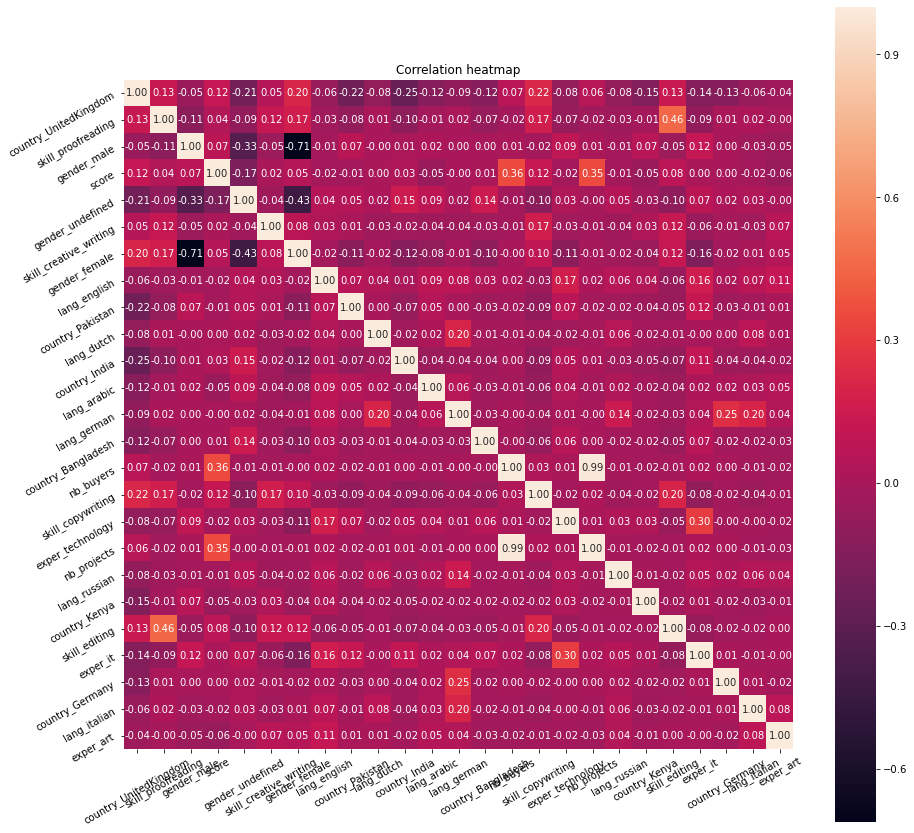

In [61]:
df = pd.DataFrame(X)
corr_matrix = df.corr()

plt.figure(figsize=(15,15))
plt.title('Correlation heatmap')
a = sns.heatmap(corr_matrix, square=True, annot=True, fmt='.2f', linecolor='black')
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()    

<AxesSubplot:>

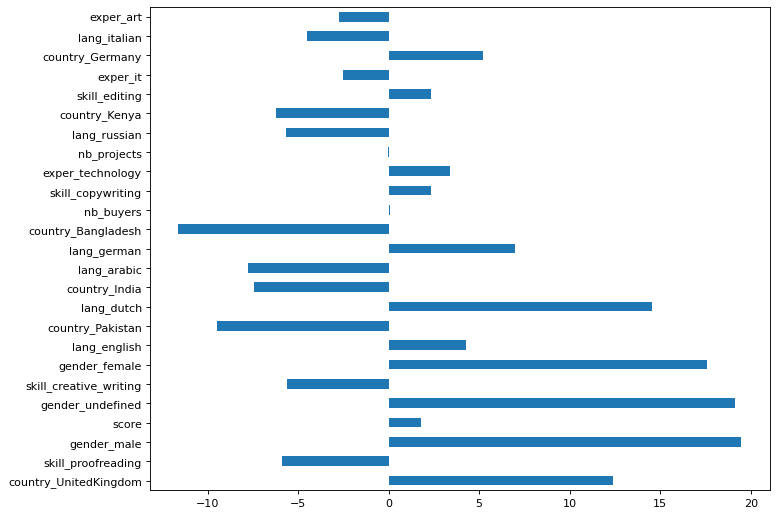

In [64]:
plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')
feat_importances = pd.Series(result.params)
feat_importances.plot(kind='barh')

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

model = sm.OLS(y_train.astype(float), X_train.astype(float))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      Price/hour in USD   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     18.35
Date:                Mon, 24 May 2021   Prob (F-statistic):           9.59e-75
Time:                        10:43:58   Log-Likelihood:                -26335.
No. Observations:                5304   AIC:                         5.272e+04
Df Residuals:                    5279   BIC:                         5.288e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
country_UnitedKingdom     12